In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm
from scipy.stats import qmc
import math
import pandas as pd

In [10]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [11]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [12]:
tf.keras.backend.set_floatx("float64")

In [13]:
class Heat1DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04)):
        super(Heat1DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model

    @tf.function
    def dirichlet_condition(self, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        x_t_time = tf.concat([x_bc_time, t_bc_time], axis=1)
        x_t_space = tf.concat([x_bc_space, t_bc_space], axis=1)
        u_time = self.model(x_t_time)
        u_space = self.model(x_t_space)
        return tf.reduce_mean(tf.square(u_time - u_bc_time)) + tf.reduce_mean(tf.square(u_space - u_bc_space))

    # @tf.function
    # def neuman_condition(self, x1_x2_bc_right):
    #     _, u_x1, _,  _, _ = self.forward(x1_x2_bc_right)
    #     return tf.reduce_mean(tf.square(u_x1)) # -∂u/∂x1 + ∂u/∂x1

    @tf.function
    def loss_fn(self, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        x_t = tf.concat([x_in, t_in], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x_in)[0]
        u_t = tf.gradients(u0, t_in)[0]
        u_xx = tf.gradients(u_x, x_in)[0]
        u_tt = tf.gradients(u_t, t_in)[0]
        heat_eq = u_t - u_xx#self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)
        #bc_neuman = self.neuman_condition(x_d, y_d, t_d)

        return tf.reduce_mean(tf.square(heat_eq)) + bc_dirichlet
    
    def train(self, loss_threshold, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        loss_array = []
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_nonstationary_heat_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1 = np.array([x[0] for x in x1_x2])
        x2 = np.array([x[1] for x in x1_x2])
        return -np.pi * np.sin(np.pi * x1) * np.sin(np.pi * x2)

In [14]:
N_of_train_points_2D = 40
N_of_test_points_2D = 1000
N_of_fem_points_2D = 20
N_of_time_steps = 100
L_x = 0.0
R_x = 1.0
L_t = 0.0
R_t = 0.2
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-3
Layers_2D = [20, 20, 20, 20, 20, 20, 20, 20, 20]
Learning_rate_2D = 1e-3
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)


model_2D = Heat1DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 20)                60        
                                                                 
 dense_11 (Dense)            (None, 20)                420       
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 20)                420   

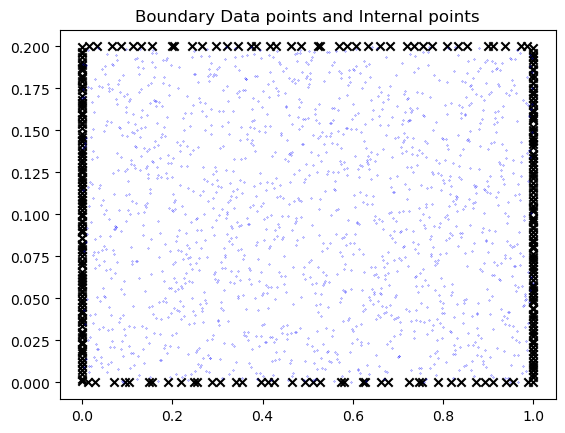

In [15]:
n_bc_space = 2
n_bc_time = 2
n_bc = 4

Nc = N_of_train_points_2D * N_of_train_points_2D

engine = qmc.LatinHypercube(d=1)
data_space = np.zeros([n_bc_space, N_of_train_points_2D, 3])
data_time = np.zeros([n_bc_time, N_of_time_steps, 3])

for i, j in zip(range(n_bc), [L_x, R_x, L_t, R_t]):
    if i < 2:
        points = qmc.scale(engine.random(n=N_of_time_steps), [L_t], [R_t])[:, 0]
        data_time[i, :, 0] = j
        data_time[i, :, 1] = points
    else:
        points = qmc.scale(engine.random(n=N_of_train_points_2D), [L_x], [R_x])[:, 0]
        data_space[i-2, :, 0] = points
        data_space[i-2, :, 1] = j

# BC Values
data_time[0, :, 2] = 0.0
data_time[1, :, 2] = 0.0
values = np.sin(math.pi*data_space[0, :, 0]) - np.sin(2*math.pi*data_space[0, :, 0]) + np.sin(3*math.pi*data_space[0, :, 0])
data_space[0, :, 2] = values

data_space = data_space.reshape(N_of_train_points_2D * n_bc_space, 3)
data_time = data_time.reshape(N_of_time_steps * n_bc_time, 3)

x_bc_time, t_bc_time, u_bc_time = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_time[:, 0], data_time[:, 1], data_time[:, 2]])

x_bc_space, t_bc_space, u_bc_space = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_space[:, 0], data_space[:, 1], data_space[:, 2]])

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = np.column_stack((L_x + colloc[:,0] * (R_x - L_x), L_t + colloc[:,1] * (R_t - L_t)))

x_in, t_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Internal points")
plt.scatter(data_time[:, 0], data_time[:, 1], marker="x", c="k", label="BDP")
plt.scatter(data_space[:, 0], data_space[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
plt.show()

x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space]
)

2024-04-17 00:33:21.351334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_42' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_42}}]]
2024-04-17 00:33:21.351504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_43' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_43}}]]
2024-04-17 00:33:22.203822: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x92e0e10 initialized for platform CUDA (this does not

Epoch 0, Loss: 0.8511012848010424
Epoch 100, Loss: 0.593260757417772
Epoch 200, Loss: 0.5478322384815635
Epoch 300, Loss: 0.4123574041047525
Epoch 400, Loss: 0.38509614432865125
Epoch 500, Loss: 0.372250519875948
Epoch 600, Loss: 0.3314878424559238
Epoch 700, Loss: 0.2975850413614615
Epoch 800, Loss: 0.2602233204039066
Epoch 900, Loss: 0.22661390702090423
Epoch 1000, Loss: 0.20224660973092468
Epoch 1100, Loss: 0.2170104245328523
Epoch 1200, Loss: 0.21942364792631758
Epoch 1300, Loss: 0.15280874206108297
Epoch 1400, Loss: 0.14210926152140932
Epoch 1500, Loss: 0.13104805925880925
Epoch 1600, Loss: 0.12722946890896392
Epoch 1700, Loss: 0.11879647432043501
Epoch 1800, Loss: 0.1314982388119899
Epoch 1900, Loss: 0.10643871545246723
Epoch 2000, Loss: 0.11134860549307646
Epoch 2100, Loss: 0.12133009593209812
Epoch 2200, Loss: 0.11047715366049354
Epoch 2300, Loss: 0.10826827760198936
Epoch 2400, Loss: 0.1179911935133241
Epoch 2500, Loss: 0.09503719623383548
Epoch 2600, Loss: 0.11334913446623092

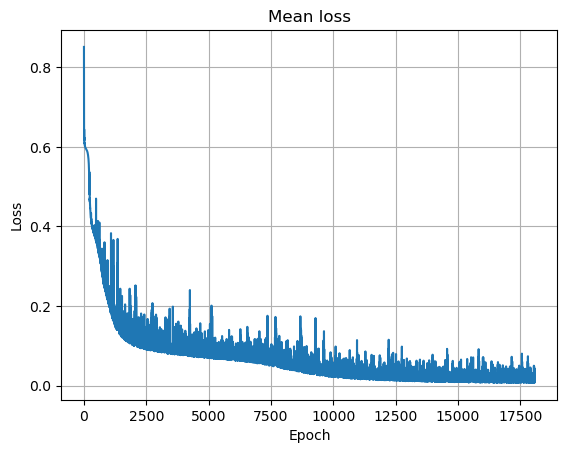

In [16]:
model_2D.train(loss_threshold_2D, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)

In [51]:
x_test = np.linspace(L_x, R_x, N_of_test_points_2D)
t_test = np.linspace(L_t, R_t, N_of_time_steps)
x_mesh, t_mesh = np.meshgrid(x_test, t_test)
xt_test = np.column_stack([x_mesh.ravel(), t_mesh.ravel()])


u_pinn = model_2D.model(xt_test).numpy().reshape(t_test.size, x_test.size)

(100, 1000)


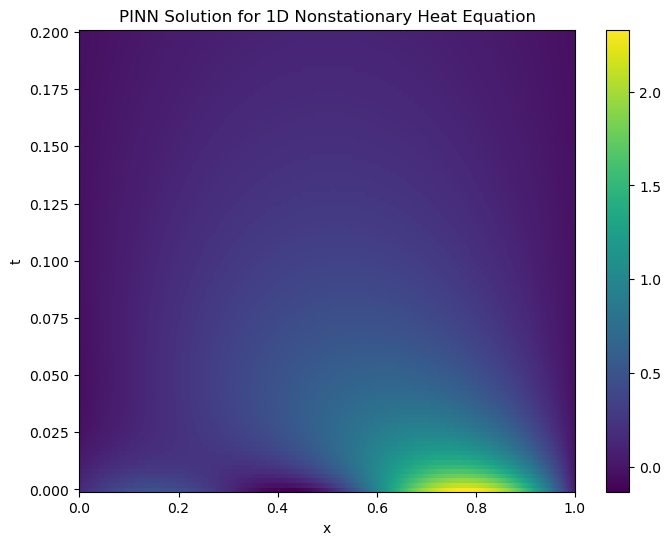

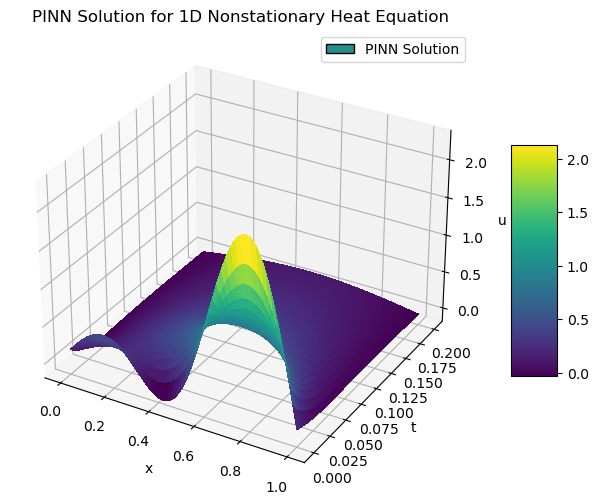

In [52]:
plt.figure(figsize=(8, 6))
plt.pcolor(x_mesh, t_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Solution for 1D Nonstationary Heat Equation')
plt.savefig("1d_nonstationary_heat_exact_solution_heatmap.png")
plt.show(block=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# line, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, u_pred_1D, label='PINN Solution 1D', zorder=2)
# line2, = ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D', zorder=1)
surf = ax.plot_surface(x_mesh, t_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
#ax.plot(np.ones_like(x_test_1D) * 0.5, x_test_1D, U_exact_1D, label='Exact Solution 1D')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.set_title('PINN Solution for 1D Nonstationary Heat Equation')
color_for_legend = cm.viridis(0.5)  # Get the color from the colormap
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution'])
#ax.legend([line, line2, proxy], ['PINN Solution 1D', 'Exact Solution 1D', 'PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("1d_nonstationary_heat_approx_solution.png")
plt.show()

In [53]:
from fenics import *

def solve_with_fem(N_coarse, N_fine, N_time):
    mesh = IntervalMesh(N_coarse-1, L_x, R_x)
    V = FunctionSpace(mesh, 'P', 1)

    # Define boundary conditions
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, Constant(0), boundary)

    # Initial condition
    u_0 = Expression('sin(pi*x[0]) - sin(2*pi*x[0]) + sin(3*pi*x[0])', degree=2)
    u_n = interpolate(u_0, V)

    # Define the variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Constant(0)
    alpha = Constant(1.0)
    dt = (R_t - L_t) / N_time
    F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
    a, L = lhs(F), rhs(F)

    # Time stepping
    u = Function(V)
    u_fem = np.zeros((N_time, N_fine))  # Array to store interpolated values

    for n in range(N_time):
        solve(a == L, u, bc)
        u_n.assign(u)
        
        # Interpolate to a finer mesh at each time step
        fine_mesh = IntervalMesh(N_fine-1, L_x, R_x)
        V_fine = FunctionSpace(fine_mesh, 'P', 1)
        u_fine = interpolate(u, V_fine)
        u_fem[n, :] = u_fine.compute_vertex_values()

    return u_fem

# Solve the PDE
u_fem = solve_with_fem(50, N_of_test_points_2D, N_of_time_steps)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [ ]:
# from fenics import *
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize

# N = N_of_test_points_2D-1
# mesh = IntervalMesh(N, L_x, R_x)

# V = FunctionSpace(mesh, 'P', 1)

# def boundary_left(x, on_boundary):
#     return on_boundary and near(x[0], L_x)

# def boundary_right(x, on_boundary):
#     return on_boundary and near(x[0], R_x)

# bc = [DirichletBC(V, Constant(0), boundary_left),
#       DirichletBC(V, Constant(0), boundary_right)]

# u_0 = Expression('sin(pi*x[0]) - sin(2*pi*x[0]) + sin(3*pi*x[0])', degree=2)
# u_n = interpolate(u_0, V)

# u = TrialFunction(V)
# v = TestFunction(V)
# f = Constant(0)
# alpha = Constant(1.0)
# dt = (R_t - L_t) / N

# F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
# a, L = lhs(F), rhs(F)

# times = np.arange(L_t, R_t + dt/2, dt)
# u_fem = np.zeros((len(times), N_of_test_points_2D))

# u = Function(V)
# for n, t in enumerate(times):
#     solve(a == L, u, bc)
#     u_n.assign(u)
#     u_fem[n, :] = u.compute_vertex_values(mesh)

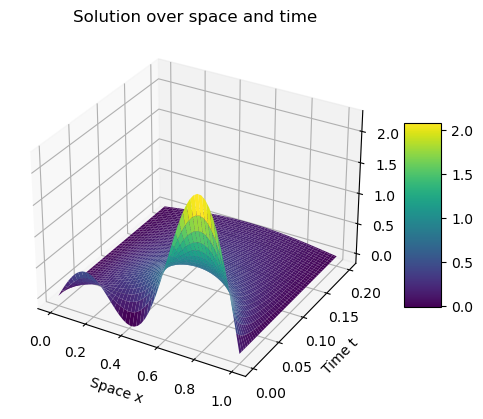

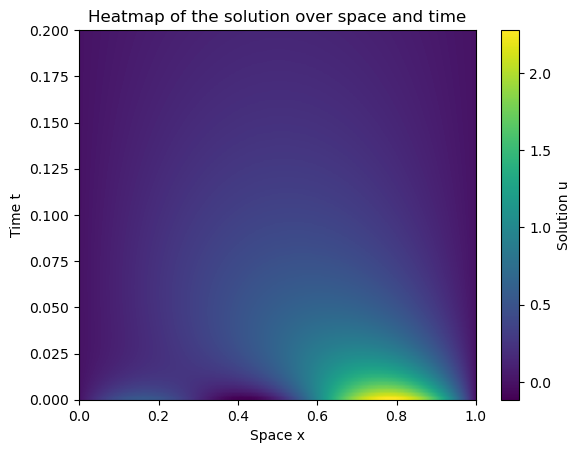

In [54]:
# Create meshgrid for plotting
X, T = np.meshgrid(np.linspace(L_x, R_x, N_of_test_points_2D), np.linspace(L_t, R_t, N_of_time_steps))

# Plot 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, u_fem, cmap='viridis')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_zlabel('Solution u')
ax.set_title('Solution over space and time')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

# Plot heatmap of the solution
fig, ax = plt.subplots()
c = ax.imshow(u_fem, extent=[L_x, R_x, L_t, R_t], origin='lower', aspect='auto', cmap='viridis')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Heatmap of the solution over space and time')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Solution u')
plt.show()

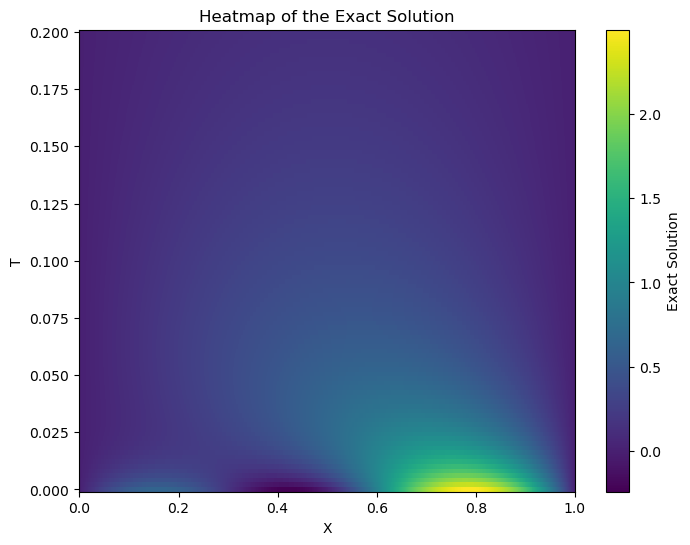

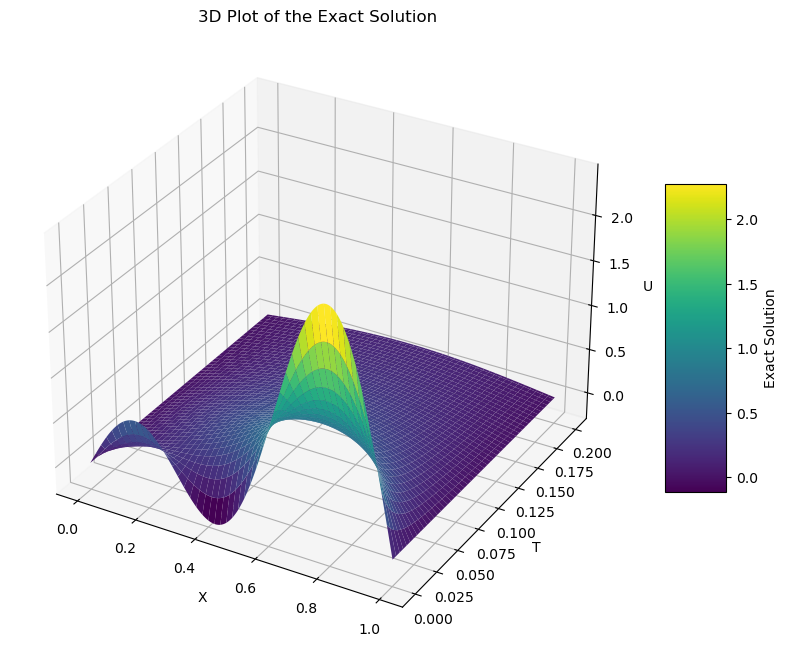

In [61]:
def exact_solution(x, t):
    term1 = np.exp(-np.power(np.pi, 2) * t) * np.sin(np.pi * x)
    term2 = -np.exp(-np.power(2 * np.pi, 2) * t) * np.sin(2 * np.pi * x)
    term3 = np.exp(-np.power(3 * np.pi, 2) * t) * np.sin(3 * np.pi * x)
    return term1 + term2 + term3


x = np.linspace(L_x, R_x, N_of_test_points_2D)
t = np.linspace(L_t, R_t, N_of_time_steps)
X, T = np.meshgrid(x, t)

u_exact = exact_solution(X, T)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, u_exact, cmap='viridis', shading='auto')
plt.colorbar(label='Exact Solution')
plt.xlabel('X')
plt.ylabel('T')
plt.title('Heatmap of the Exact Solution')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, T, u_exact, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Exact Solution')

ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('U')
ax.set_title('3D Plot of the Exact Solution')
plt.show()

In [62]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [63]:
def relative_l2_norm_error(u_pred, u_true):
    error_norm = np.linalg.norm(u_true - u_pred)
    true_norm = np.linalg.norm(u_true)
    return error_norm / true_norm

In [65]:
print("Mean Squared Error (PINN and FEM):", np.mean((u_fem - u_pinn)**2))
relative_error_max = calculate_max_relative_error(u_fem, u_pinn)
print(f"Relative error (PINN and FEM): {relative_error_max:.2f}%")
relative_l2_error = relative_l2_norm_error(u_fem, u_pinn)
print(f"Relative l_2 error (PINN and FEM): {relative_l2_error:.2f}%")

Mean Squared Error (PINN and FEM): 0.0005748663717158582
Relative error (PINN and FEM): 6.37%
Relative l_2 error (PINN and FEM): 0.06%


In [66]:
print("Mean Squared Error (PINN and Exact):", np.mean((u_exact - u_pinn)**2))
relative_error_max = calculate_max_relative_error(u_exact, u_pinn)
print(f"Relative error (PINN and Exact): {relative_error_max:.2f}%")
relative_l2_error = relative_l2_norm_error(u_exact, u_pinn)
print(f"Relative l_2 error (PINN and Exact): {relative_l2_error:.2f}%")

Mean Squared Error (PINN and Exact): 0.0008641735727834203
Relative error (PINN and Exact): 8.14%
Relative l_2 error (PINN and Exact): 0.07%


In [67]:
print("Mean Squared Error (FEM and Exact):", np.mean((u_fem - u_exact)**2))
relative_error_max = calculate_max_relative_error(u_fem, u_exact)
print(f"Relative error (FEM and Exact): {relative_error_max:.2f}%")
relative_l2_error = relative_l2_norm_error(u_fem, u_exact)
print(f"Relative l_2 error (FEM and Exact): {relative_l2_error:.2f}%")

Mean Squared Error (FEM and Exact): 0.0004136601666973636
Relative error (FEM and Exact): 9.29%
Relative l_2 error (FEM and Exact): 0.05%


In [105]:
u_fem_10 = solve_with_fem(11, N_of_test_points_2D, N_of_time_steps)
u_fem_20 = solve_with_fem(21, N_of_test_points_2D, N_of_time_steps)
u_fem_50 = solve_with_fem(51, N_of_test_points_2D, N_of_time_steps)
#u_fem_100 = solve_with_fem(100, N_of_test_points_2D-1, N_of_time_steps)


x_positions = np.linspace(L_x, R_x, N_of_test_points_2D)
t_positions = np.linspace(L_t, R_t, N_of_time_steps)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

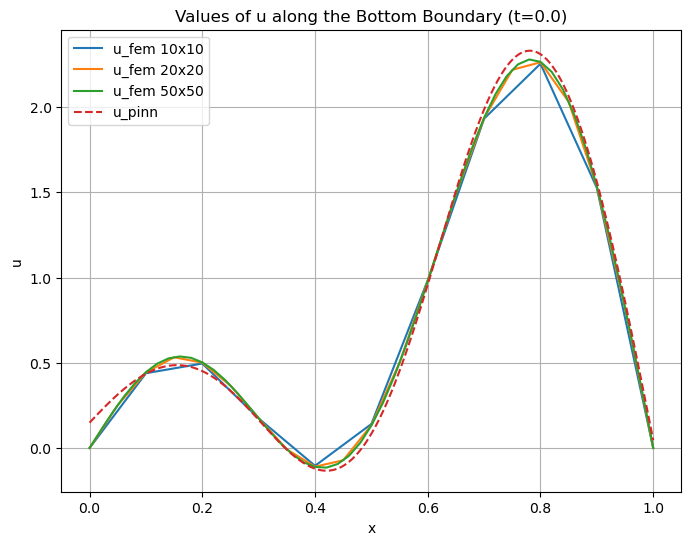

In [107]:
bottom_index = 0
bottom_boundary_fem_values_10 = u_fem_10[bottom_index, :]
bottom_boundary_fem_values_20 = u_fem_20[bottom_index, :]
bottom_boundary_fem_values_50 = u_fem_50[bottom_index, :]
bottom_boundary_pinn_values = u_pinn[bottom_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, bottom_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x_positions, bottom_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x_positions, bottom_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x_positions, bottom_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along the Bottom Boundary (t={t_positions[bottom_index]})')
plt.legend()
plt.grid(True)
plt.show()

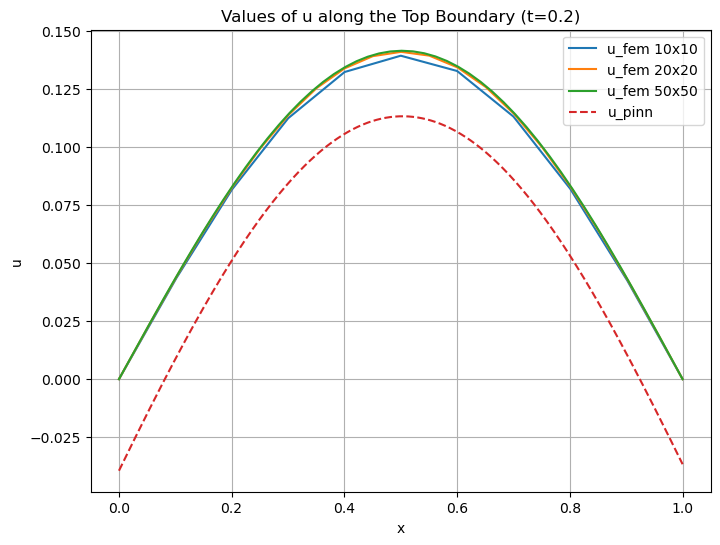

In [109]:
top_index = -1
top_boundary_fem_values_10 = u_fem_10[top_index, :]
top_boundary_fem_values_20 = u_fem_20[top_index, :]
top_boundary_fem_values_50 = u_fem_50[top_index, :]
top_boundary_pinn_values = u_pinn[top_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, top_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x_positions, top_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x_positions, top_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x_positions, top_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along the Top Boundary (t={t_positions[top_index]})')
plt.legend()
plt.grid(True)
plt.show()

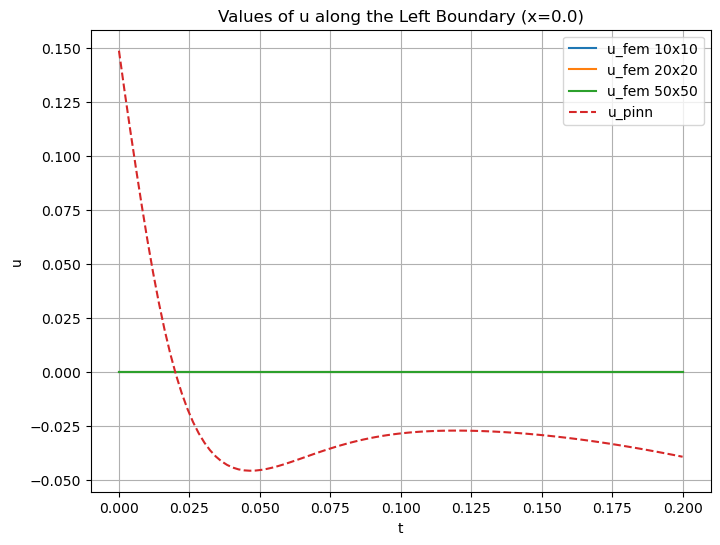

In [111]:
left_index = 0
left_boundary_fem_values_10 = u_fem_10[:, left_index]
left_boundary_fem_values_20 = u_fem_20[:, left_index]
left_boundary_fem_values_50 = u_fem_50[:, left_index]
left_boundary_pinn_values = u_pinn[:, left_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, left_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(t_positions, left_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(t_positions, left_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(t_positions, left_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along the Left Boundary (x={x_positions[left_index]})')
plt.legend()
plt.grid(True)
plt.show()

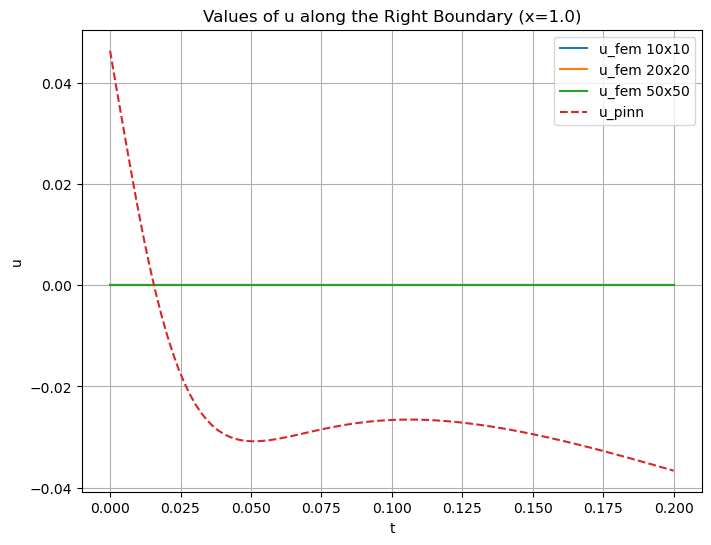

In [112]:
right_index = -1
right_boundary_fem_values_10 = u_fem_10[:, right_index]
right_boundary_fem_values_20 = u_fem_20[:, right_index]
right_boundary_fem_values_50 = u_fem_50[:, right_index]
right_boundary_pinn_values = u_pinn[:, right_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, right_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(t_positions, right_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(t_positions, right_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(t_positions, right_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along the Right Boundary (x={x_positions[right_index]})')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
# Indices for 11 equally spaced points including both ends (0 and 1)
indices_x = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error
indices_t = np.linspace(0, N_of_time_steps - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error

# Creating a table for the selected points
data_top = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": top_boundary_fem_values_10[indices_x],
    "FEM 20x20": top_boundary_fem_values_20[indices_x],
    "FEM 50x50": top_boundary_fem_values_50[indices_x],
    "PINN": top_boundary_pinn_values[indices_x]
}

df_top = pd.DataFrame(data_top)
print(f"Values on top boundary (t={t_positions[top_index]}):")
print(df_top)

data_bottom = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": bottom_boundary_fem_values_10[indices_x],
    "FEM 20x20": bottom_boundary_fem_values_20[indices_x],
    "FEM 50x50": bottom_boundary_fem_values_50[indices_x],
    "PINN": bottom_boundary_pinn_values[indices_x]
}

df_bottom = pd.DataFrame(data_bottom)
print(f"Values on bottom boundary (t={t_positions[bottom_index]}):")
print(df_bottom)



Values on top boundary (t=0.2):
           x     FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000  0.000000e+00   0.000000   0.000000 -0.039457
1   0.099099  4.244939e-02   0.042923   0.043058  0.008237
2   0.199199  8.123312e-02   0.082155   0.082417  0.050735
3   0.299299  1.121589e-01   0.113458   0.113827  0.084111
4   0.399399  1.321930e-01   0.133762   0.134208  0.105549
5   0.499499  1.393291e-01   0.141026   0.141509  0.113257
6   0.599600  1.328005e-01   0.134459   0.134932  0.106595
7   0.699700  1.131805e-01   0.114625   0.115037  0.086080
8   0.799800  8.235141e-02   0.083420   0.083724  0.053362
9   0.899900  4.333575e-02   0.043904   0.044065  0.011211
10  1.000000 -1.922760e-17   0.000000   0.000000 -0.036657
Values on bottom boundary (t=0.0):
           x     FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000  0.000000e+00   0.000000   0.000000  0.148531
1   0.099099  4.347767e-01   0.440168   0.441984  0.433844
2   0.199199  4.949805e-01   0.501282   0.503325

In [114]:
data_left = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": left_boundary_fem_values_10[indices_t],
    "FEM 20x20": left_boundary_fem_values_20[indices_t],
    "FEM 50x50": left_boundary_fem_values_50[indices_t],
    "PINN": left_boundary_pinn_values[indices_t]
}

df_left = pd.DataFrame(data_left)
print(f"Values on left boundary (x={x_positions[left_index]}):")
print(df_left)


data_right = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": right_boundary_fem_values_10[indices_t],
    "FEM 20x20": right_boundary_fem_values_20[indices_t],
    "FEM 50x50": right_boundary_fem_values_50[indices_t],
    "PINN": right_boundary_pinn_values[indices_t]
}

df_right = pd.DataFrame(data_right)
print(f"Values on right boundary (x={x_positions[right_index]}):")
print(df_right)

Values on left boundary (x=0.0):
           t  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000        0.0        0.0        0.0  0.148531
1   0.018182        0.0        0.0        0.0  0.008387
2   0.038384        0.0        0.0        0.0 -0.043253
3   0.058586        0.0        0.0        0.0 -0.042940
4   0.078788        0.0        0.0        0.0 -0.034133
5   0.098990        0.0        0.0        0.0 -0.028796
6   0.119192        0.0        0.0        0.0 -0.027351
7   0.139394        0.0        0.0        0.0 -0.028285
8   0.159596        0.0        0.0        0.0 -0.030794
9   0.179798        0.0        0.0        0.0 -0.034598
10  0.200000        0.0        0.0        0.0 -0.039457
Values on right boundary (x=1.0):
           t     FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000 -6.775128e-16        0.0        0.0  0.046398
1   0.018182 -2.943126e-16        0.0        0.0 -0.005798
2   0.038384 -1.577791e-16        0.0        0.0 -0.028696
3   0.058586 -1.026920e-1

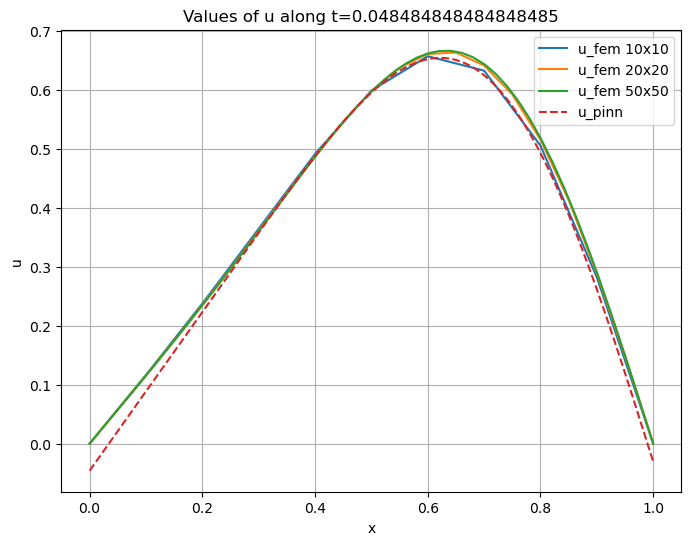

In [131]:
bottom_offset_index = int((0.05 - L_t) / ((R_t - L_t) / (N_of_time_steps - 1)))
bottom_offset_boundary_fem_values_10 = u_fem_10[bottom_offset_index, :]
bottom_offset_boundary_fem_values_20 = u_fem_20[bottom_offset_index, :]
bottom_offset_boundary_fem_values_50 = u_fem_50[bottom_offset_index, :]
bottom_offset_boundary_pinn_values = u_pinn[bottom_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, bottom_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x_positions, bottom_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x_positions, bottom_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x_positions, bottom_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along t={t_positions[bottom_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

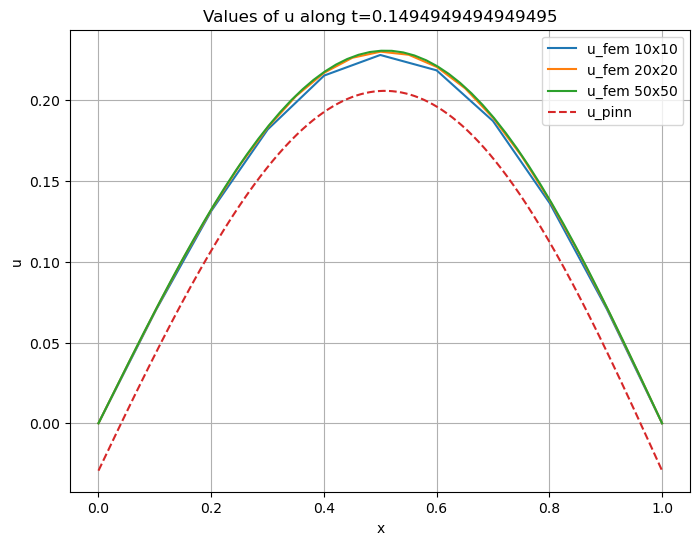

In [132]:
top_offset_index = int((0.15 - L_t) / ((R_t - L_t) / (N_of_time_steps - 1)))
top_offset_boundary_fem_values_10 = u_fem_10[top_offset_index, :]
top_offset_boundary_fem_values_20 = u_fem_20[top_offset_index, :]
top_offset_boundary_fem_values_50 = u_fem_50[top_offset_index, :]
top_offset_boundary_pinn_values = u_pinn[top_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, top_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(x_positions, top_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(x_positions, top_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(x_positions, top_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along t={t_positions[top_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

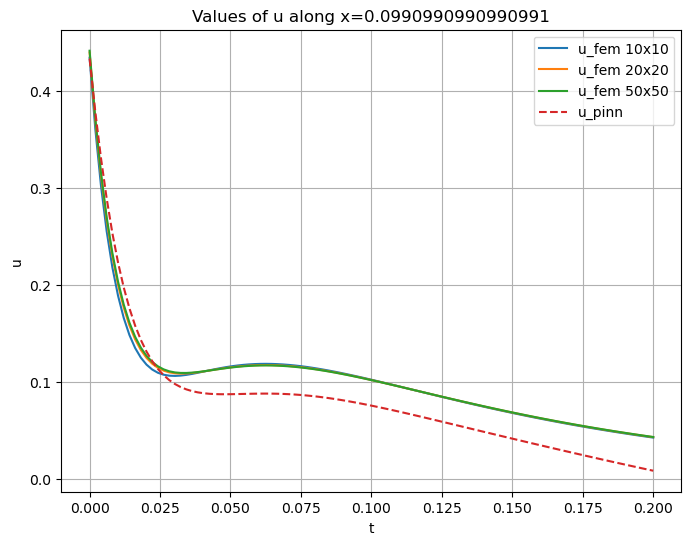

In [133]:
left_offset_index = int((0.1 - L_x) / ((R_x - L_x) / (N_of_test_points_2D - 1)))
left_offset_boundary_fem_values_10 = u_fem_10[:, left_offset_index]
left_offset_boundary_fem_values_20 = u_fem_20[:, left_offset_index]
left_offset_boundary_fem_values_50 = u_fem_50[:, left_offset_index]
left_offset_boundary_pinn_values = u_pinn[:, left_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, left_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(t_positions, left_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(t_positions, left_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(t_positions, left_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along x={x_positions[left_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

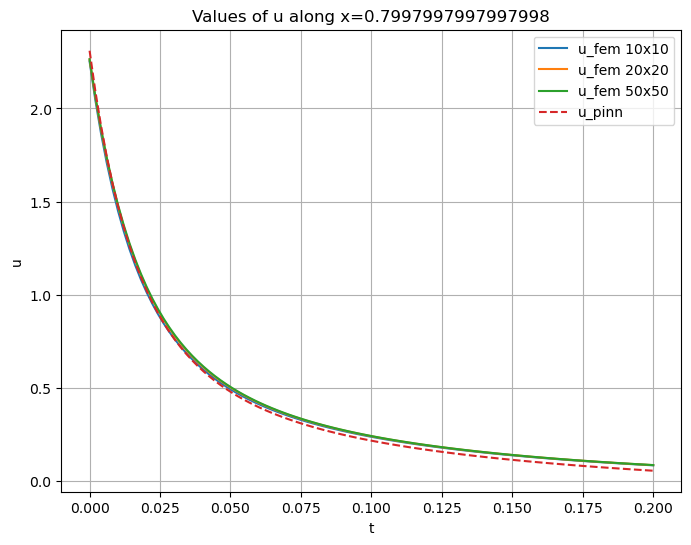

In [134]:
right_offset_index = int((0.8 - L_x) / ((R_x - L_x) / (N_of_test_points_2D - 1)))
right_offset_boundary_fem_values_10 = u_fem_10[:, right_offset_index]
right_offset_boundary_fem_values_20 = u_fem_20[:, right_offset_index]
right_offset_boundary_fem_values_50 = u_fem_50[:, right_offset_index]
right_offset_boundary_pinn_values = u_pinn[:, right_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, right_offset_boundary_fem_values_10, label='u_fem 10x10')
plt.plot(t_positions, right_offset_boundary_fem_values_20, label='u_fem 20x20')
plt.plot(t_positions, right_offset_boundary_fem_values_50, label='u_fem 50x50')
plt.plot(t_positions, right_offset_boundary_pinn_values, '--', label='u_pinn')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along x={x_positions[right_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
# Indices for 11 equally spaced points including both ends (0 and 1)
indices_x = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error
indices_t = np.linspace(0, N_of_time_steps - 1, 11, dtype=int)  # Corrected to avoid out-of-bounds error

# Creating a table for the selected points
data_top_offset = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": top_offset_boundary_fem_values_10[indices_x],
    "FEM 20x20": top_offset_boundary_fem_values_20[indices_x],
    "FEM 50x50": top_offset_boundary_fem_values_50[indices_x],
    "PINN": top_offset_boundary_pinn_values[indices_x]
}

df_top_offset = pd.DataFrame(data_top_offset)
print(f"Values at t={t_positions[top_offset_index]}:")
print(df_top_offset)

data_bottom_offset = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": bottom_offset_boundary_fem_values_10[indices_x],
    "FEM 20x20": bottom_offset_boundary_fem_values_20[indices_x],
    "FEM 50x50": bottom_offset_boundary_fem_values_50[indices_x],
    "PINN": bottom_offset_boundary_pinn_values[indices_x]
}

df_bottom_offset = pd.DataFrame(data_bottom_offset)
print(f"Values at t={t_positions[bottom_offset_index]}:")
print(df_bottom_offset)



Values at t=0.1494949494949495:
           x     FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000  0.000000e+00   0.000000   0.000000 -0.029366
1   0.099099  6.822722e-02   0.068628   0.068739  0.041729
2   0.199199  1.309190e-01   0.131756   0.131991  0.106402
3   0.299299  1.815269e-01   0.182826   0.183192  0.158286
4   0.399399  2.150894e-01   0.216832   0.217327  0.192566
5   0.499499  2.280280e-01   0.230112   0.230706  0.205789
6   0.599600  2.186064e-01   0.220828   0.221464  0.196229
7   0.699700  1.872790e-01   0.189353   0.189948  0.164270
8   0.799800  1.368254e-01   0.138438   0.138902  0.112550
9   0.899900  7.219033e-02   0.073073   0.073327  0.045813
10  1.000000 -3.203023e-17   0.000000   0.000000 -0.029377
Values at t=0.048484848484848485:
           x     FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000  0.000000e+00   0.000000   0.000000 -0.045838
1   0.099099  1.152314e-01   0.114370   0.114189  0.087215
2   0.199199  2.362958e-01   0.233976   0.233389 

In [136]:
data_left_offset = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": left_offset_boundary_fem_values_10[indices_t],
    "FEM 20x20": left_offset_boundary_fem_values_20[indices_t],
    "FEM 50x50": left_offset_boundary_fem_values_50[indices_t],
    "PINN": left_offset_boundary_pinn_values[indices_t]
}

df_left_offset = pd.DataFrame(data_left_offset)
print(f"Values at x={x_positions[left_offset_index]}:")
print(df_left_offset)


data_right_offset = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": right_offset_boundary_fem_values_10[indices_t],
    "FEM 20x20": right_offset_boundary_fem_values_20[indices_t],
    "FEM 50x50": right_offset_boundary_fem_values_50[indices_t],
    "PINN": right_offset_boundary_pinn_values[indices_t]
}

df_right_offset = pd.DataFrame(data_right_offset)
print(f"Values at x={x_positions[right_offset_index]}:")
print(df_right_offset)

Values at x=0.0990990990990991:
           t  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   0.434777   0.440168   0.441984  0.433844
1   0.018182   0.125018   0.132981   0.135386  0.143358
2   0.038384   0.109376   0.109886   0.110131  0.089171
3   0.058586   0.118376   0.117096   0.116768  0.087797
4   0.078788   0.114674   0.113727   0.113463  0.085428
5   0.098990   0.102909   0.102565   0.102464  0.076053
6   0.119192   0.088628   0.088717   0.088738  0.062913
7   0.139394   0.074683   0.075014   0.075106  0.048778
8   0.159596   0.062199   0.062643   0.062768  0.034770
9   0.179798   0.051474   0.051953   0.052090  0.021208
10  0.200000   0.042449   0.042923   0.043058  0.008237
Values at x=0.7997997997997998:
           t  FEM 10x10  FEM 20x20  FEM 50x50      PINN
0   0.000000   2.253421   2.262457   2.265145  2.310378
1   0.018182   1.082294   1.105888   1.112715  1.094038
2   0.038384   0.623490   0.637294   0.641353  0.616019
3   0.058586   0.421116   0.428907   0.4